In [709]:
#Autoreload to be able to tweak source code in the fly without restarting kernel
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [710]:
%autoreload 2

In [711]:
import aligater as ag

In [712]:
fcsList=ag.collectFiles("/media/ludvig/Project_Storage/GAIM/data/GAIM_fcs/", lFilter=["B cells"])

Collected 2983 files, 6268 files did not pass filter(s) and mask(s).


In [713]:
fcsDF = ag.loadFCS(fcsList[500], compensate=True,markers=["IgA", "CD27" ,"CD34" ,"CD19", "IgD" ,"CD45","CD38","CD24"])

Opening file B cells_G5_G05_044 from folder /08-03-2016/plate 1
Loaded dataset with 448200 events.
Marker labels: IgA CD27 CD34 CD19 IgD CD45 CD38 CD24 


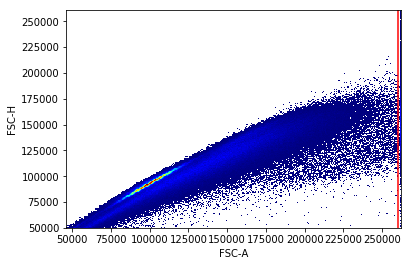

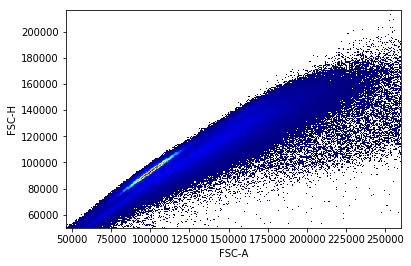

After gating, 438882 out of 448200 events remain.


In [714]:
no_clutter=ag.gateThreshold(fcsDF,"FSC-A", "FSC-H",thresh=260000, orientation='vertical',population="lower")

After gating, 430739 out of 438882 events remain.


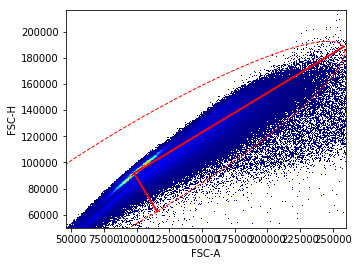

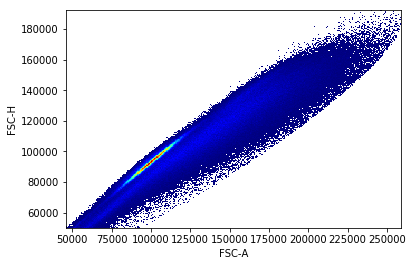

In [715]:
singlets=ag.gatePC(fcsDF,"FSC-A", "FSC-H",center='density',widthScale=4, heightScale=4, vI=no_clutter, plot=True)

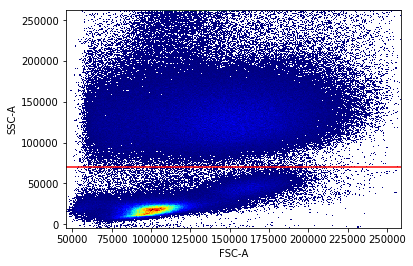

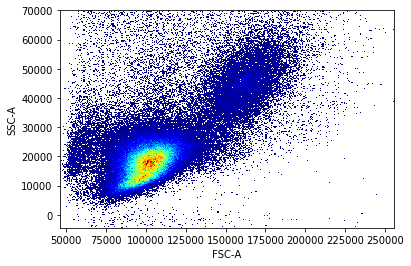

After gating, 170835 out of 430739 events remain.


In [716]:
PBMCstep1=ag.gateThreshold(fcsDF,xCol="FSC-A",yCol="SSC-A",vI=singlets, orientation="horisontal",thresh=70000,population="lower")

After gating, 157170 out of 170835 events remain.


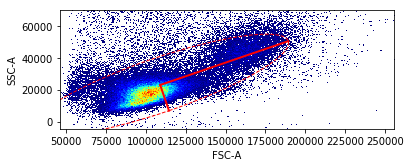

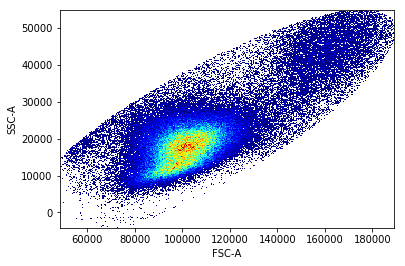

In [717]:
PBMC=ag.gatePC(fcsDF,"FSC-A","SSC-A",center='centroid',widthScale=3, heightScale=2, vI=PBMCstep1, plot=True)

In [718]:
mean, sigma, maxVal=ag.axisStats(fcsDF, "CD34", PBMC,scale='logish')
sigma*2

1980.9487431282387

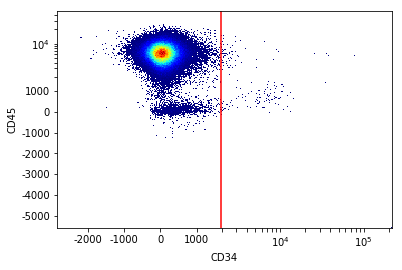

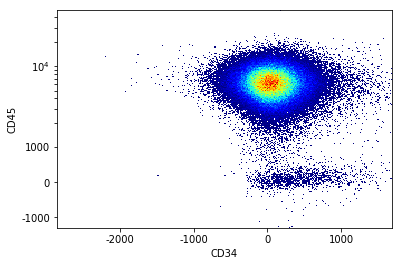

After gating, 156962 out of 157170 events remain.


In [719]:
CD45step1 = ag.gateThreshold(fcsDF, "CD34", "CD45", orientation='vertical', vI=PBMC,population="lower",thresh=2*sigma, scale='logish')

In [720]:
lim = ag.valleySeek(fcsDF, "CD45",vI=CD45step1,interval=[0,2500],sigma=2,bins=1000)

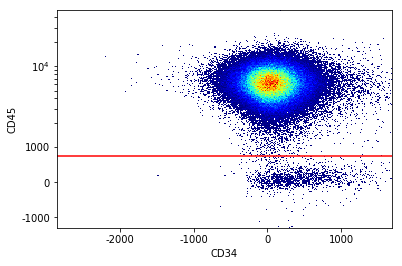

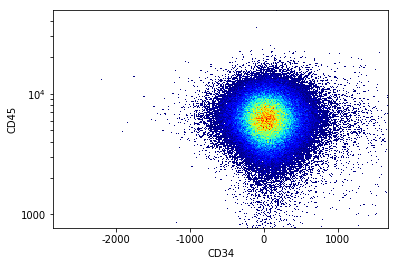

After gating, 154785 out of 156962 events remain.


In [721]:
CD45pos = ag.gateThreshold(fcsDF, "CD34", "CD45", vI=CD45step1, orientation='horisontal',thresh=lim,scale='logish') 

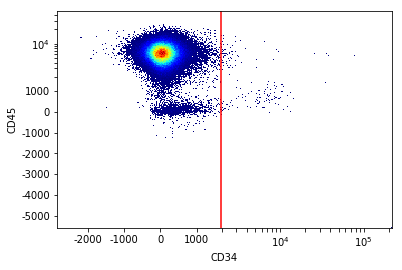

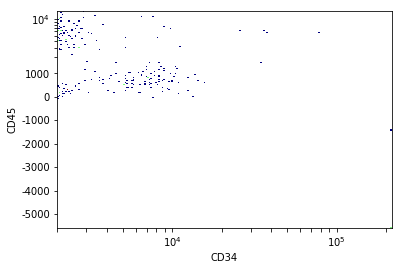

After gating, 208 out of 157170 events remain.


In [722]:
CD34step1=ag.gateThreshold(fcsDF, "CD34", "CD45", orientation='vertical', vI=PBMC,population="upper",thresh=2*sigma, scale='logish')

(<matplotlib.figure.Figure at 0x7f4169cdf160>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4169cdafd0>)

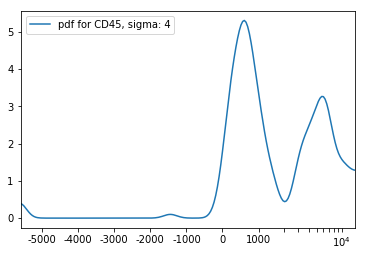

In [723]:
ag.plot_densityFunc(fcsDF,"CD45", vI=CD34step1,sigma=4,bins=200, scale='logish')

In [724]:
lim=ag.valleySeek(fcsDF, "CD45",vI=CD34step1,interval=[500,2500],sigma=2,bins=200,scale='logish')
lim

1942.6347591999972

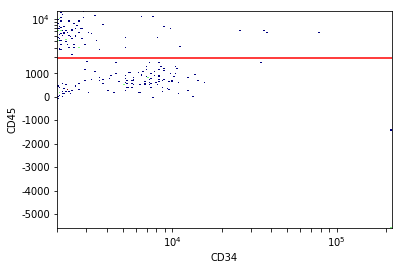

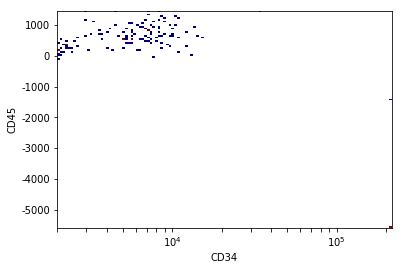

After gating, 123 out of 208 events remain.


In [725]:
CD34pos=ag.gateThreshold(fcsDF, "CD34", "CD45", orientation='horisontal', vI=CD34step1,population="lower",thresh=lim, scale='logish')

(<matplotlib.figure.Figure at 0x7f4169db2908>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4169d9e198>)

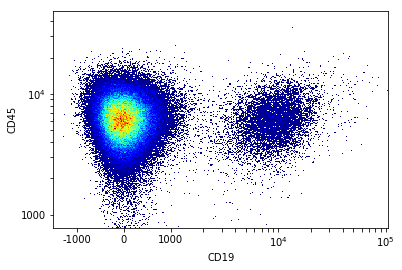

In [726]:
ag.plotHeatmap(fcsDF, "CD19","CD45",vI=CD45pos,scale='logish')

(<matplotlib.figure.Figure at 0x7f4169fe43c8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4169e69a90>)

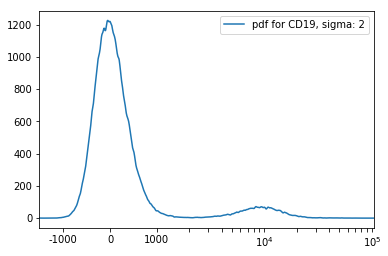

In [727]:
ag.plot_densityFunc(fcsDF,xCol="CD19",vI=CD45pos, bins=1000, sigma=2, scale='logish')

In [728]:
lim=ag.valleySeek(fcsDF,xCol="CD19",vI=CD45pos,interval=[0,2000],bins=1000,sigma=2, scale='logish')

In [729]:
lim

2005.0624163389471

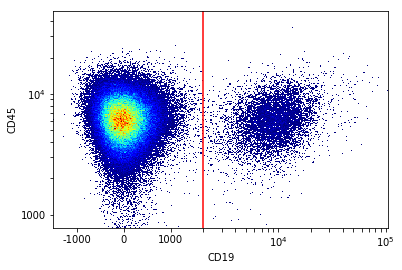

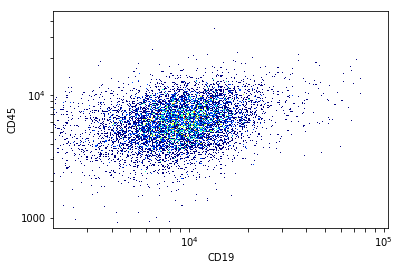

After gating, 10853 out of 154785 events remain.


In [730]:
CD19pos=ag.gateThreshold(fcsDF,"CD19","CD45",vI=CD45pos,thresh=lim,scale='logish',orientation='vertical',population='upper')

(<matplotlib.figure.Figure at 0x7f4178390b70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f416bb56dd8>)

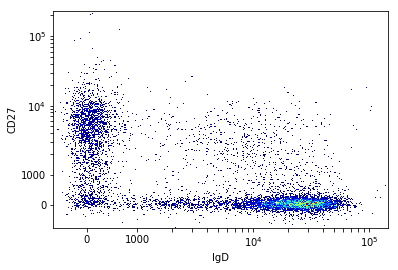

In [731]:
ag.plotHeatmap(fcsDF, "IgD", "CD27", vI=CD19pos,scale="logish",bins=300)

In [732]:
xlim=ag.valleySeek(fcsDF,"IgD", CD19pos, interval=[500,2500],bins=300,sigma=2, scale='logish')

In [733]:
ylim=ag.valleySeek(fcsDF,"CD27", CD19pos, interval=[500,1000],bins=300,sigma=2, scale='logish')

Input quadgate solution score: 0.186333327847
Tested 20 solution(s) excluding the input solution
Best solution had score: 0.186333327847


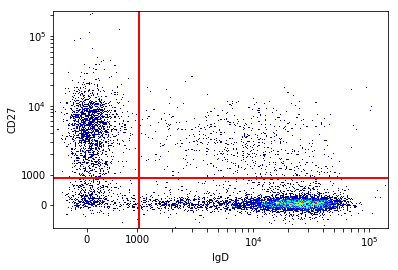

In [734]:
solution = ag.variableQuadGate(fcsDF, "IgD", "CD27", [xlim, xlim, ylim, ylim], testRange=[2000,3000], position='left', vI=CD19pos,scale='logish',only_solution=True, plot=True, scoreThresh=0.6)

Input quadgate solution score: 0.186333327847
Tested 20 solution(s) excluding the input solution
Best solution had score: 0.186333327847


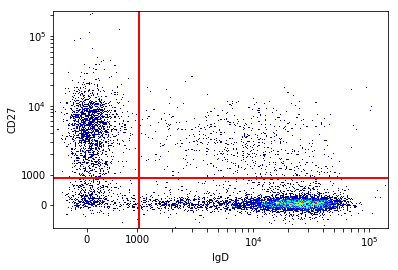

In [735]:
switchB, preSwitchB, naiveB, exhaustedB,solution = ag.variableQuadGate(fcsDF, "IgD", "CD27", solution, testRange=[0,ylim], position='right', vI=CD19pos,scale='logish', plot=True)

(<matplotlib.figure.Figure at 0x7f417b694f98>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4183121278>)

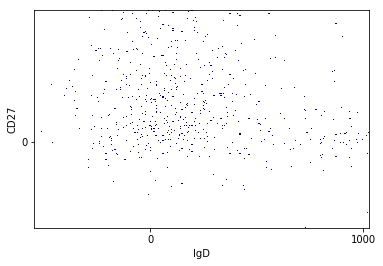

In [736]:
ag.plotHeatmap(fcsDF, "IgD", "CD27", vI=exhaustedB, scale='logish')

In [737]:
mean, sigma, maxVal = ag.axisStats(fcsDF, "CD38", vI=switchB)

(<matplotlib.figure.Figure at 0x7f416bf9ecc0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4182941ac8>)

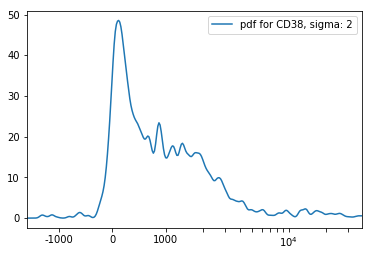

In [738]:
ag.plot_densityFunc(fcsDF,"CD38",switchB,scale='logish',bins=300,sigma=2)

In [739]:
def gatePlasmablasts(fcsDF, vI):
    solutions=[]
    for testThresh in range(2000,5000,500):
        plasmablasts,doublePos,tmp1,tmp2=ag.quadGate(fcsDF, "CD24", "CD38",1000,testThresh,vI=vI,scale='logish',plot=False)
        solutions.append([(len(plasmablasts)-len(doublePos)),testThresh])
    maxVal=-ag.np.inf
    maxThresh=testThresh
    for solution in solutions:
        if solution[0]>maxVal:
            maxVal=solution[0]
            maxThresh=solution[1]
    reportStr="best solution score: "+str(maxVal)+" with thresh: "+str(maxThresh)+"\n"
    ag.sys.stderr.write(reportStr)
    return maxThresh

In [740]:
CD38thresh=gatePlasmablasts(fcsDF,switchB)

best solution score: 113 with thresh: 4000


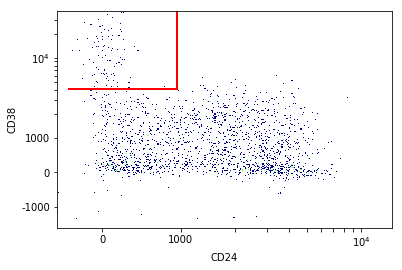

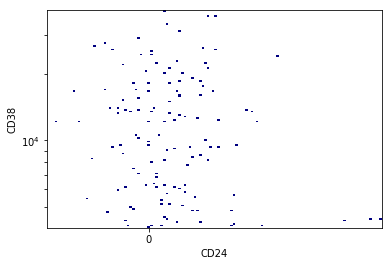

After gating, 130 out of 2473 events remain.


In [741]:
plasmablasts=ag.gateCorner(fcsDF, "CD24", "CD38",1000,CD38thresh,"lower","upper", vI=switchB,scale='logish')

In [742]:
xmean,xsigma,xmaxVal = ag.axisStats(fcsDF,xCol="CD24",vI=naiveB)

In [743]:
ymean,ysigma,ymaxVal = ag.axisStats(fcsDF,xCol="CD38",vI=naiveB)

In [744]:
[xmean, xsigma, xmaxVal]

[746.2338737255177, 528.43153670590425, 618.31861938694317]

In [745]:
[ymean, ysigma, ymaxVal]

[1532.3579982541735, 1618.3668207368057, 780.25463122249403]

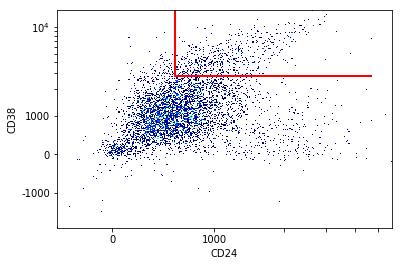

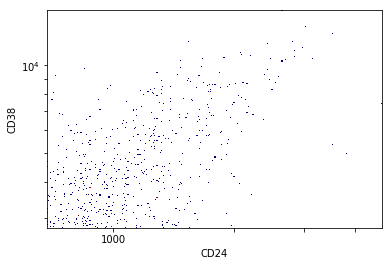

After gating, 773 out of 6776 events remain.


In [746]:
transitionals=ag.gateCorner(fcsDF,"CD24", "CD38",xThresh = xmaxVal, yThresh=ymaxVal+2000, vI=naiveB, scale='logish')

In [747]:
lim = ag.valleySeek(fcsDF,"IgA",vI=switchB,interval=[750,2000],bins=300, sigma=1, scale='logish')
lim

1809.2431461199608

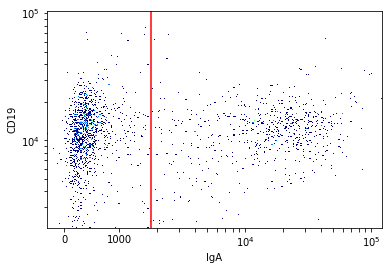

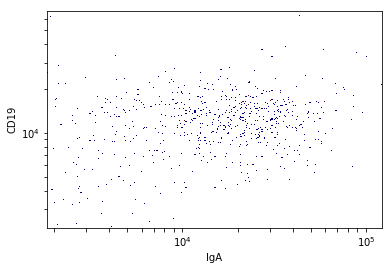

After gating, 871 out of 2473 events remain.


In [748]:
IgApos=ag.gateThreshold(fcsDF, "IgA","CD19", orientation='vertical', vI=switchB, thresh=lim, scale='logish')